<a href="https://colab.research.google.com/github/ar4199/Brain_Tumor_MRI_Imaging/blob/main/mri_imaging_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow matplotlib

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = "/content/drive/MyDrive/projects/mri project/Tumour/train"
valid_dir = "/content/drive/MyDrive/projects/mri project/Tumour/valid"
test_dir  = "/content/drive/MyDrive/projects/mri project/Tumour/test"

In [ ]:
def count_images(directory):
    for tumor_type in os.listdir(directory):
        class_dir = os.path.join(directory, tumor_type)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            print(f"{tumor_type}: {count} images")

print("🔹 Train set:")
count_images(train_dir)

print("\n🔹 Validation set:")
count_images(valid_dir)

print("\n🔹 Test set:")
count_images(test_dir)


🔹 Train set:
glioma: 564 images
meningioma: 358 images
no_tumor: 335 images
pituitary: 438 images

🔹 Validation set:
glioma: 161 images
meningioma: 124 images
no_tumor: 99 images
pituitary: 118 images

🔹 Test set:
glioma: 80 images
meningioma: 63 images
no_tumor: 49 images
pituitary: 54 images


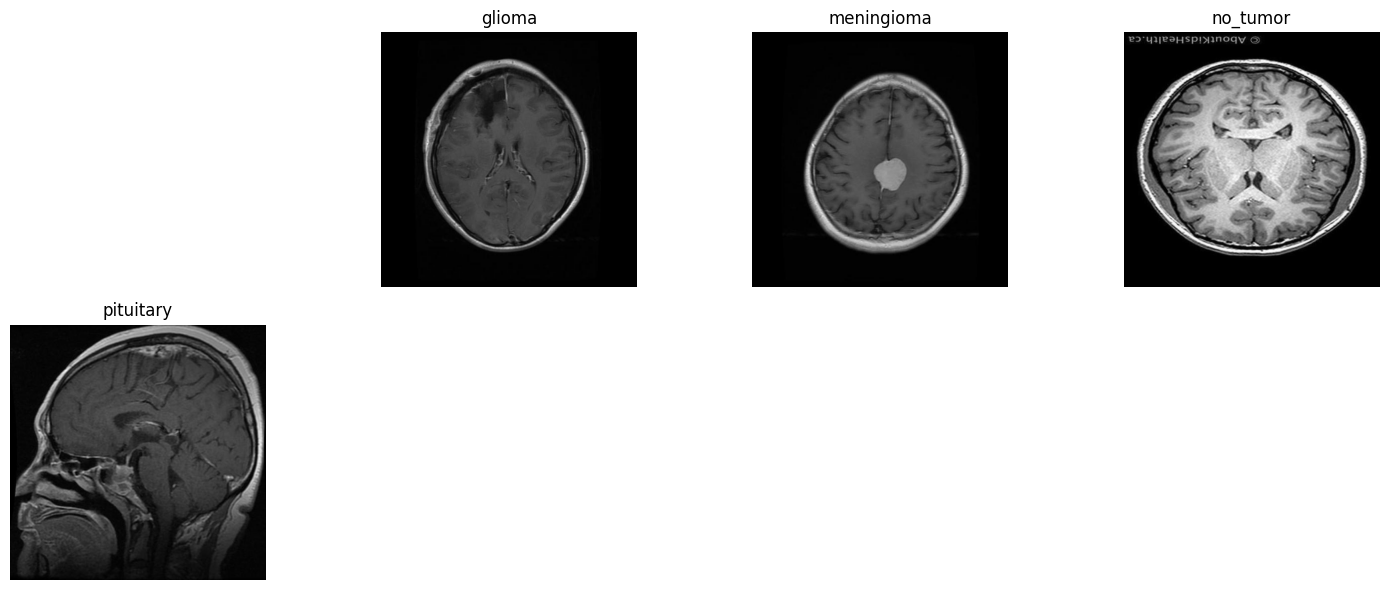

In [ ]:
import matplotlib.image as mpimg
import random

def show_sample_images(data_dir, rows=2, cols=4):
    tumor_types = os.listdir(data_dir)
    plt.figure(figsize=(15, 6))

    for i, tumor_type in enumerate(tumor_types):
        tumor_path = os.path.join(data_dir, tumor_type)
        if not os.path.isdir(tumor_path): continue
        img_name = random.choice(os.listdir(tumor_path))
        img_path = os.path.join(tumor_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(tumor_type)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(train_dir)

In [ ]:
image_shapes = []

for tumor_type in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, tumor_type)
    if os.path.isdir(class_dir):  # Add this check
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            image_shapes.append(img.size)

unique_sizes = set(image_shapes)
print(f"Unique image sizes found: {len(unique_sizes)}")
print(unique_sizes)

Unique image sizes found: 1
{(640, 640)}


In [ ]:
image_size = (224, 224)
batch_size = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation & Test generators
val_test_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle= False  # Important for correct test evaluation
)


print("Class indices:", train_generator.class_indices)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


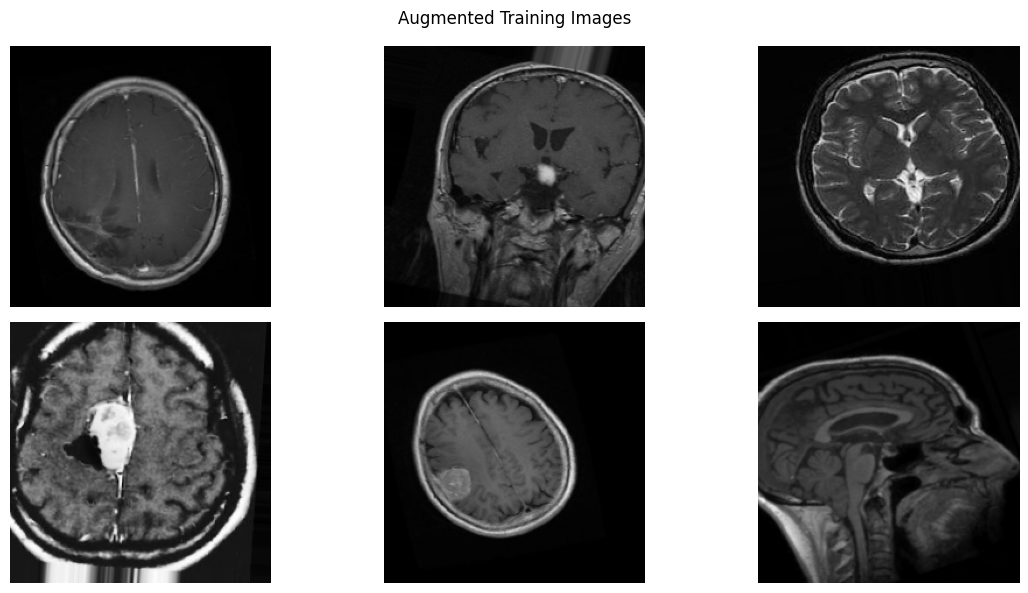

In [ ]:
# Get one batch of images
x_batch, y_batch = next(train_generator)

# Show 6 augmented images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.suptitle("Augmented Training Images")
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

custom_cnn = Sequential([
    # First Conv Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Conv Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Conv Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense Layers
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
custom_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_custom_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)


In [ ]:
history = custom_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5181 - loss: 5.8740

53/53 ━━━━━━━━━━━━━━━━━━━━ 476s 9s/step - accuracy: 0.5189 - loss: 5.8231 - val_accuracy: 0.3207 - val_loss: 23.9460
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 336s 6s/step - accuracy: 0.5946 - loss: 1.2453 - val_accuracy: 0.2590 - val_loss: 15.3612
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5736 - loss: 1.2162

53/53 ━━━━━━━━━━━━━━━━━━━━ 362s 7s/step - accuracy: 0.5735 - loss: 1.2159 - val_accuracy: 0.4363 - val_loss: 11.3486
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 337s 6s/step - accuracy: 0.5740 - loss: 1.0946 - val_accuracy: 0.3068 - val_loss: 14.6553
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6164 - loss: 1.0524

53/53 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.6164 - loss: 1.0519 - val_accuracy: 0.4960 - val_loss: 7.7449
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6588 - loss: 0.9213

53/53 ━━━━━━━━━━━━━━━━━━━━ 340s 6s/step - accuracy: 0.6586 - loss: 0.9222 - val_accuracy: 0.5199 - val_loss: 3.0122
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 337s 6s/step - accuracy: 0.6722 - loss: 0.9152 - val_accuracy: 0.4263 - val_loss: 2.2894
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - accuracy: 0.6266 - loss: 0.9508 - val_accuracy: 0.3944 - val_loss: 3.1800
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 380s 6s/step - accuracy: 0.6483 - loss: 0.8516 - val_accuracy: 0.5159 - val_loss: 1.4368
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6635 - loss: 0.8538

53/53 ━━━━━━━━━━━━━━━━━━━━ 382s 6s/step - accuracy: 0.6632 - loss: 0.8539 - val_accuracy: 0.7430 - val_loss: 0.8531


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_custom_cnn_model.h5")

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

pred_probs = model.predict(test_generator)

y_pred = np.argmax(pred_probs, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))


8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step
              precision    recall  f1-score   support

      glioma       0.76      0.94      0.84        80
  meningioma       0.70      0.49      0.58        63
    no_tumor       0.92      0.49      0.64        49
   pituitary       0.66      0.94      0.78        54

    accuracy                           0.74       246
   macro avg       0.76      0.72      0.71       246
weighted avg       0.76      0.74      0.72       246



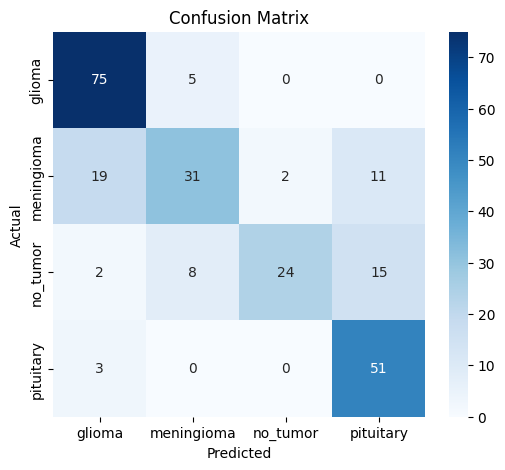

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)


In [ ]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [ ]:
resnet_ckpt = ModelCheckpoint(
    'best_resnet50_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)

resnet_earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)


In [ ]:
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[resnet_ckpt, resnet_earlystop])


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2761 - loss: 1.8597
Epoch 1: val_accuracy improved from -inf to 0.45817, saving model to best_resnet50_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 436s 8s/step - accuracy: 0.2763 - loss: 1.8573 - val_accuracy: 0.4582 - val_loss: 1.3817
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2937 - loss: 1.5551
Epoch 2: val_accuracy did not improve from 0.45817
53/53 ━━━━━━━━━━━━━━━━━━━━ 425s 8s/step - accuracy: 0.2935 - loss: 1.5555 - val_accuracy: 0.4363 - val_loss: 1.3339
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2873 - loss: 1.5369
Epoch 3: val_accuracy did not improve from 0.45817
53/53 ━━━━━━━━━━━━━━━━━━━━ 426s 8s/step - accuracy: 0.2876 - loss: 1.5363 - val_accuracy: 0.4442 - val_loss: 1.3223
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2873 - loss: 1.4878
Epoch 4: val_accuracy did not improve from 0.45817
53/53 ━━━━━━━━━━━━━━━━━━━━ 477s 9s/step - accuracy: 0.2874 - loss: 1.4879 - val_accuracy: 0.4522 - val_loss: 1.3160
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3254 - loss: 1.4294
Epoch 5: val_accuracy improved from 0.45817 to 0.46

53/53 ━━━━━━━━━━━━━━━━━━━━ 425s 8s/step - accuracy: 0.3252 - loss: 1.4295 - val_accuracy: 0.4661 - val_loss: 1.3091
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3065 - loss: 1.4329
Epoch 6: val_accuracy improved from 0.46614 to 0.46813, saving model to best_resnet50_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 425s 8s/step - accuracy: 0.3067 - loss: 1.4329 - val_accuracy: 0.4681 - val_loss: 1.2913
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3320 - loss: 1.3789
Epoch 7: val_accuracy did not improve from 0.46813
53/53 ━━━━━━━━━━━━━━━━━━━━ 425s 8s/step - accuracy: 0.3321 - loss: 1.3790 - val_accuracy: 0.4622 - val_loss: 1.2819
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3567 - loss: 1.3598
Epoch 8: val_accuracy improved from 0.46813 to 0.49602, saving model to best_resnet50_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 426s 8s/step - accuracy: 0.3566 - loss: 1.3599 - val_accuracy: 0.4960 - val_loss: 1.2810
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3678 - loss: 1.3375
Epoch 9: val_accuracy did not improve from 0.49602
53/53 ━━━━━━━━━━━━━━━━━━━━ 442s 8s/step - accuracy: 0.3679 - loss: 1.3376 - val_accuracy: 0.4641 - val_loss: 1.2722
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3491 - loss: 1.3412
Epoch 10: val_accuracy did not improve from 0.49602
53/53 ━━━━━━━━━━━━━━━━━━━━ 427s 8s/step - accuracy: 0.3492 - loss: 1.3412 - val_accuracy: 0.4721 - val_loss: 1.2675


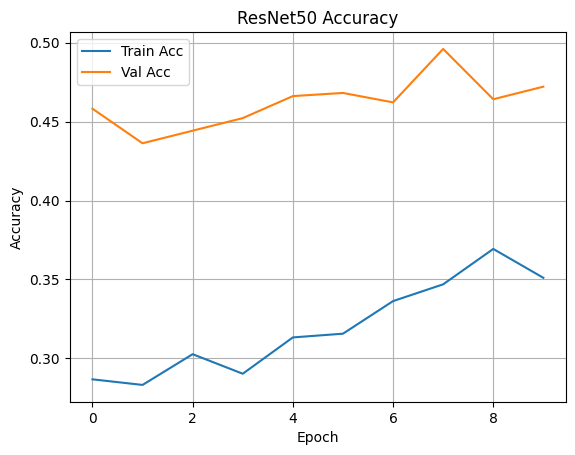

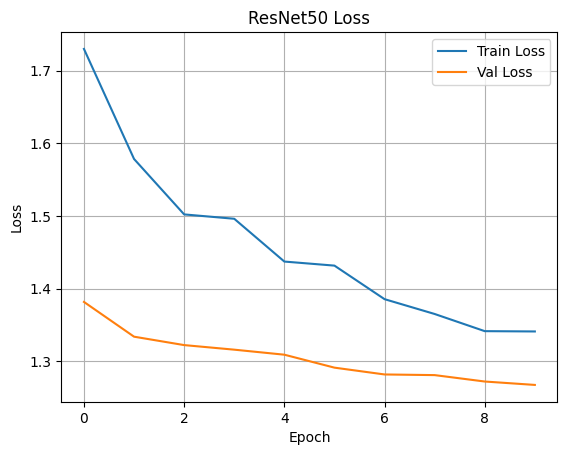

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(resnet_history.history['accuracy'], label='Train Acc')
plt.plot(resnet_history.history['val_accuracy'], label='Val Acc')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

resnet_model = load_model("best_resnet50_model.h5")


In [ ]:
# Predict class probabilities
y_pred_probs = resnet_model.predict(test_generator)

# Convert to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True class indices
y_true = test_generator.classes

# Class labels
class_names = list(test_generator.class_indices.keys())


8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

      glioma       0.44      0.97      0.61        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.50      0.67      0.57        49
   pituitary       0.75      0.06      0.10        54

    accuracy                           0.46       246
   macro avg       0.42      0.43      0.32       246
weighted avg       0.41      0.46      0.34       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


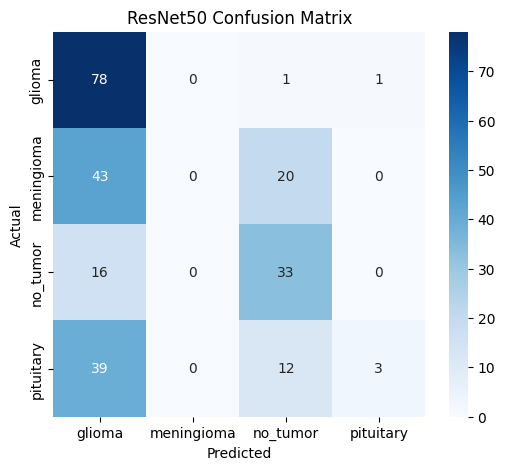

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
!pip install streamlit pyngrok tensorflow pillow --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.8 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf

# Page settings
st.set_page_config(page_title="Brain Tumor Classifier", page_icon="🧠", layout="centered")

# Load your best CNN model
@st.cache_resource
def load_model_once():
    return load_model("best_custom_cnn_model.h5")

model = load_model_once()
class_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Header
st.title("🧠 Brain Tumor MRI Classifier")
st.markdown("Upload an MRI image below to detect the **type of brain tumor**.")

# File uploader
uploaded_file = st.file_uploader("🩺 Upload MRI Image", type=["jpg", "jpeg", "png"])

# Image display and prediction
if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="🖼️ Uploaded MRI Image", use_column_width=True)

    with st.spinner("Analyzing image..."):
        # Preprocess
        img = image.resize((224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        predictions = model.predict(img_array)[0]
        predicted_index = np.argmax(predictions)
        predicted_label = class_labels[predicted_index]
        confidence = predictions[predicted_index]

    # Display results
    st.markdown("---")
    st.subheader("🔍 Prediction Result")
    st.markdown(f"**Tumor Type:** `{predicted_label.upper()}`")
    st.progress(float(confidence))
    st.markdown(f"**Confidence Score:** `{confidence*100:.2f}%`")

    # Optional: Show all class probabilities
    st.markdown("#### 📊 Class Probabilities")
    prob_data = {label: f"{prob*100:.2f}%" for label, prob in zip(class_labels, predictions)}
    st.json(prob_data)

# Footer
st.markdown("---")
st.caption("Built with ❤️ using Streamlit & TensorFlow")


2025-10-02 12:26:24.690 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 12:26:24.693 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 12:26:25.063 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-02 12:26:25.065 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 12:26:25.067 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 12:26:25.068 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-02 12:26:25.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()